In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from PIL import Image

import matplotlib.pyplot as plt

# Know your Data

In [2]:
# Design custom dataset.
class SiameseDataset(torch.utils.data.Dataset):
    def __init__(self, image_list, transform=None):
        self.image_list = image_list
        self.transform = transform

    def __getitem__(self, index):
        img1 = self.image_list[index][0]
        img2 = self.image_list[index][1]
        label = self.image_list[index][2]
        
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            label = self.transform(label)

        return img1, img2, label

    def __len__(self):
        return len(self.image_list)

# Transformations and Augmentations

---

Each image undergoes 5 types of <b>Data Augmentation</b>:
+ Horizontal Flip
+ Vertical Flip
+ Rotation by 90 degrees
+ Rotation by 180 degrees
+ Rotation by 270 degrees

---

<b>Transformations</b> include converting PIL image to a Tensor object 

In [3]:
# Define the crop size
crop_size = (448, 784)

# Define a custom lambda function to crop the image.
crop_fn = lambda x: x[:, :crop_size[0], :crop_size[1]]

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(crop_fn),
    
])

augmentations = [
    lambda x: TF.hflip(x),  # Horizontal flip
    lambda x: TF.vflip(x),  # Vertical flip
    lambda x: TF.rotate(x, 90),  # 90-degree rotation
    lambda x: TF.rotate(x, 180),  # 180-degree rotation
    lambda x: TF.rotate(x, 270),  # 270-degree rotation
]

In [4]:
data_list = []
for i in range(7):
    data_path = f'SZTAKI_AirChange_Benchmark/Szada/{i + 1}/'
    data_list.append((data_path + "im1.bmp", data_path + "im2.bmp", data_path + "gt.bmp"))

for i in range(5):
    data_path = f'SZTAKI_AirChange_Benchmark/Tiszadob/{i + 1}/'
    data_list.append((data_path + "im1.bmp", data_path + "im2.bmp", data_path + "gt.bmp"))

print(f'The number of images in the dataset before augmentation of each image = {len(data_list)}')

# Image list after applying the augmentations on the each image.
train_image_list = []
augmented_train_image_list = []
test_image_list = []

for (img1_path, img2_path, label_path) in data_list:
    img1 = Image.open(img1_path).convert('RGB')
    img2 = Image.open(img2_path).convert('RGB')
    label = Image.open(label_path).convert('L') 
    
    # Add the the whole image without augmentations to the test list of images.
    test_image_list.append((img1, img2, label))
    
    # Convert PIL images to PyTorch Tensors for easier slicing
    transform = transforms.ToTensor()
    tensor_img1 = transform(img1)
    tensor_img2 = transform(img2)
    tensor_label = transform(label)
    
    train_image_size = 112
    x_index = img1.size[0] - crop_size[0]
    y_index = img1.size[1] - crop_size[1]
    
    # Divide the remaining image after cropping top left part into two rectangles.
    # Index through rectangle number one and extract images.
    # Image size after extracting will be 112 x 112
    for i in range(0, img1.size[1], 22):
        if(i + train_image_size >= img1.size[1]):
            break

        train_image_list.append(((tensor_img1[:, 
                                              i : i + train_image_size, 
                                              y_index : y_index + train_image_size]), 
                                (tensor_img2[:, 
                                             i : i + train_image_size, 
                                             y_index : y_index + train_image_size]), 
                                (tensor_label[:, 
                                              i : i + train_image_size, 
                                              y_index : y_index + train_image_size])))
    
    # Index through rectangle number two and extract images.
    for i in range(0, img1.size[0], 22):
        if(i + train_image_size >= img1.size[0]):
            break

        train_image_list.append(((tensor_img1[:, 
                                              x_index : x_index + train_image_size, 
                                              i : i + train_image_size]), 
                                 (tensor_img2[:, 
                                              x_index : x_index + train_image_size, 
                                              i : i + train_image_size]), 
                                 (tensor_label[:, 
                                               x_index : x_index + train_image_size, 
                                               i : i + train_image_size])))

# Apply augmentations to each image that was extracted for training
for (img1, img2, label) in train_image_list:
    for augment in augmentations:
        augmented_train_image_list.append((augment(img1), augment(img2), augment(label)))

The number of images in the dataset before augmentation of each image = 12


In [5]:
# Train dataset and dataloader.
train_siamese_dataset = SiameseDataset(augmented_train_image_list)
train_siamese_dataloader = torch.utils.data.DataLoader(train_siamese_dataset, batch_size=64, shuffle=False)

# Print the information about the train dataset and dataloader.
print(f'The number of images in the train dataset after augmentation of each image = {len(train_siamese_dataset)}')
print(f'The number of batches in the test dataset = {len(train_siamese_dataloader)}')

# Test dataset and dataloader.
test_siamese_dataset = SiameseDataset(test_image_list, transform=test_transform)
test_siamese_dataloader = torch.utils.data.DataLoader(test_siamese_dataset, batch_size=64, shuffle=False)

# Print the information about the test dataset and dataloader.
print(f'\nThe number of images in the test dataset = {len(test_siamese_dataset)}')
print(f'The number of batches in the test dataset = {len(test_siamese_dataloader)}')

The number of images in the train dataset after augmentation of each image = 3780
The number of batches in the test dataset = 60

The number of images in the test dataset = 12
The number of batches in the test dataset = 1


The shape of images is torch.Size([3, 112, 112])
The number of images in one batch = 64


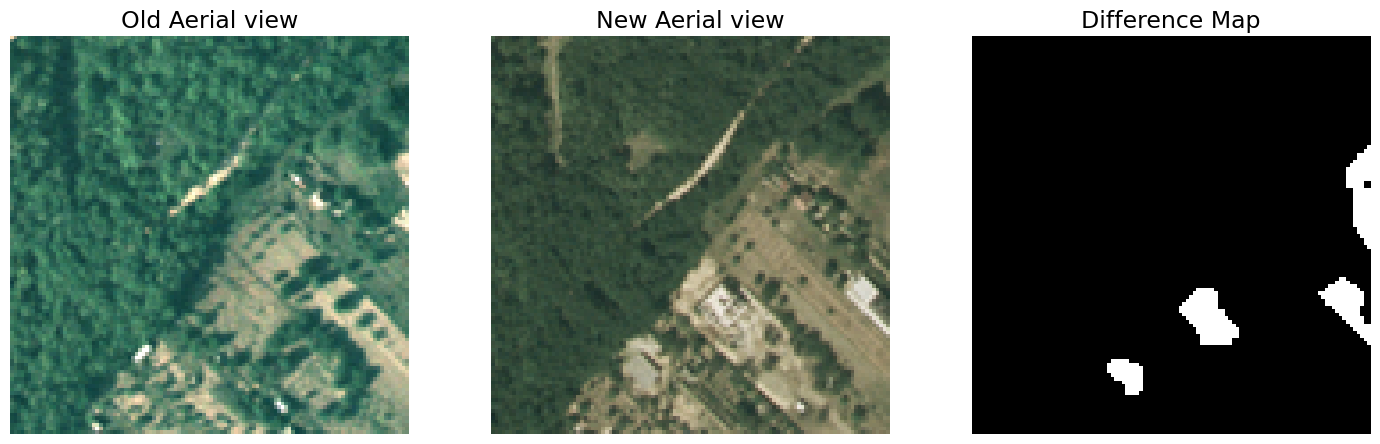

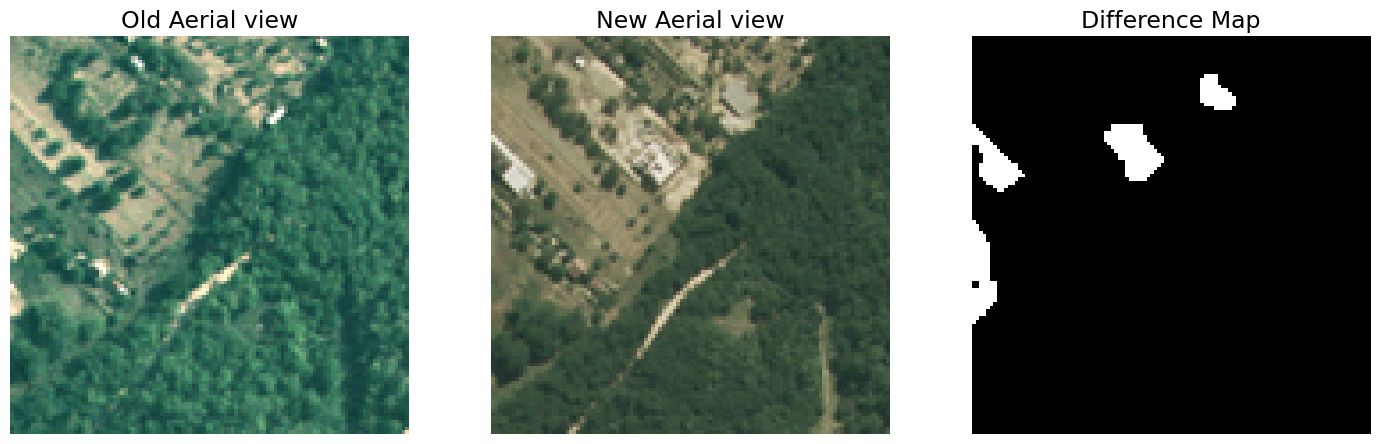

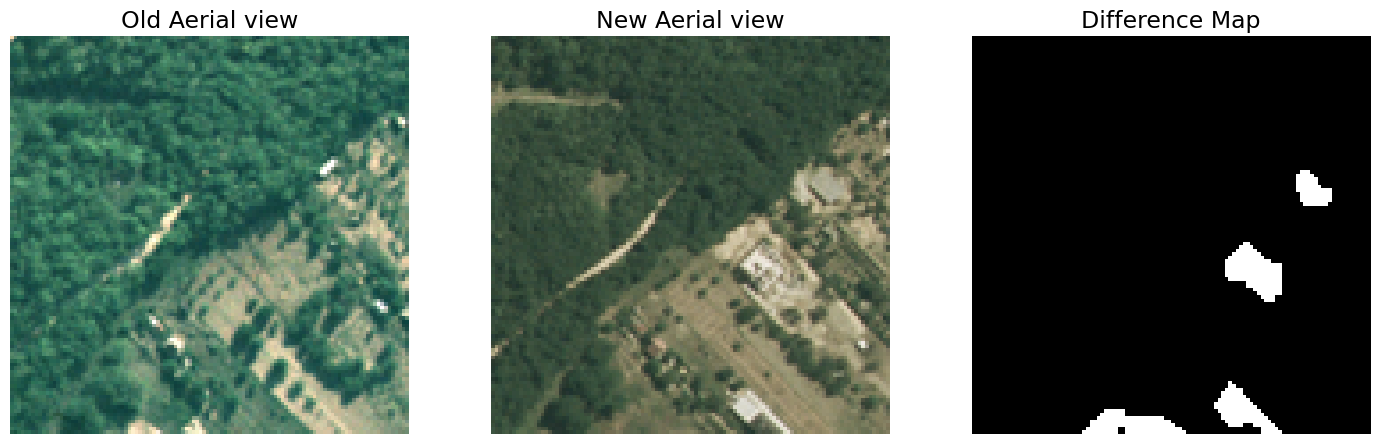

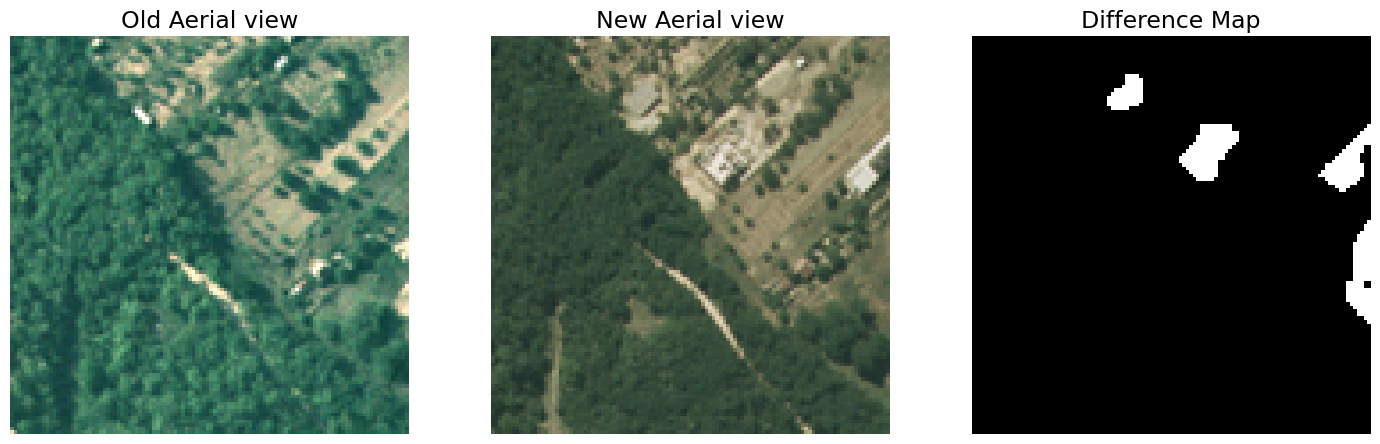

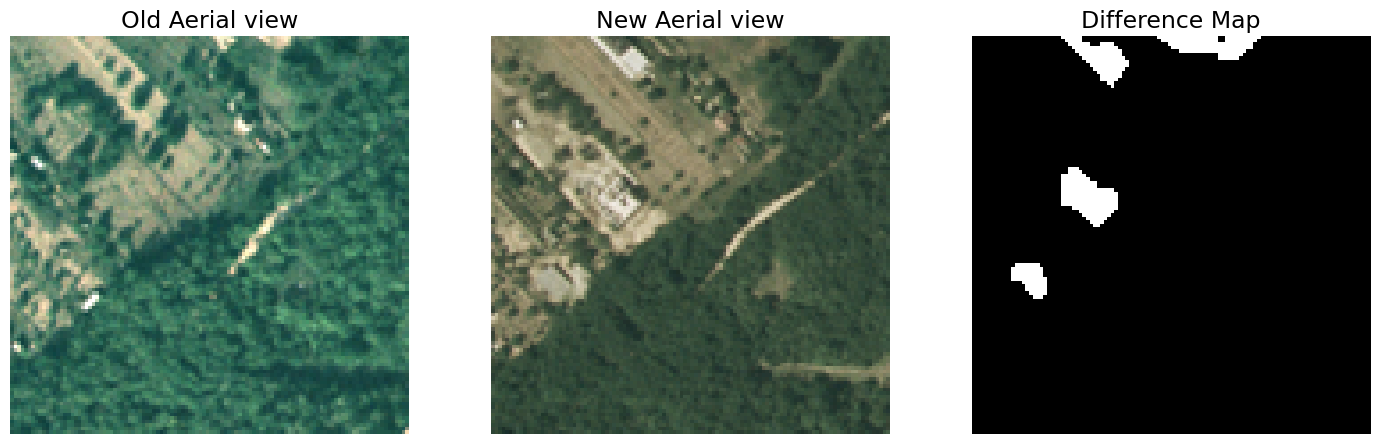

In [6]:
# Loop runs for iterations = number of batches. 
# We have only one batch for this dataset with batch_size = min(total number of images, 64).
for img1, img2, labels in train_siamese_dataloader:
    
    print(f'The shape of images is {img1.shape[1:]}')
    print(f'The number of images in one batch = {img1.shape[0]}')
    
    # You can vary the number_of_images value to print the number of images (set of 3) you need.
    number_of_images = 5 # maximum size of img1.shape[0].
    
    for i, j in zip([x for x in range(number_of_images)], [(max(3, number_of_images) * x + 1) for x in range(number_of_images)]):
        
        # Process old image.
        # Transpose is applied to all images to get the image in the form HWC from CHW.
        image1 = img1[i].transpose(0, 2).transpose(0, 1)

        plt.figure(figsize = (30, 30))
        plt.subplot(number_of_images, max(3, number_of_images), j)
        plt.imshow(image1)
        plt.axis('off')
        plt.title('Old Aerial view', fontsize = '17')

        # Process new image.
        image2 = img2[i].transpose(0, 2).transpose(0, 1)   

        plt.subplot(number_of_images, max(3, number_of_images), j + 1)
        plt.imshow(image2)
        plt.axis('off')
        plt.title('New Aerial view', fontsize = '17')

        # Process difference map label.
        label = labels[i].transpose(0, 2).transpose(0, 1)

        plt.subplot(number_of_images, max(3, number_of_images), j + 2)
        plt.imshow(label, cmap = 'gray')
        plt.axis('off')
        plt.title('Difference Map', fontsize = '17')
    
    break        